In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Use a VARMA model to predict `realdpi` and `realcons`

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


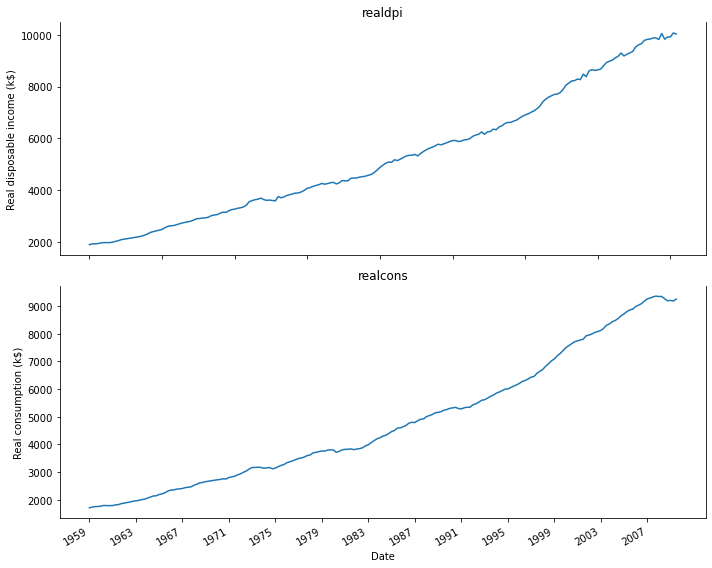

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.9860253519546847
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.5499123380509605
p-value: 0.9976992503412904


Both series are not statioanry. Let's try differencing.

In [5]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845249
p-value: 0.0006479282158627514


Both series are now stationary. We can start modeling!

In [6]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding AIC
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMA = optimize_VARMA(train, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070078
1,"(2, 1)",3124.097241
2,"(1, 3)",3125.142489
3,"(3, 2)",3125.427987
4,"(2, 3)",3125.762991
5,"(1, 2)",3126.990514
6,"(3, 1)",3129.005116
7,"(1, 1)",3129.661091
8,"(2, 2)",3129.938984
9,"(2, 0)",3130.091668


From the optimization, $p=3$ and $q=0$.

In [8]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [9]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Tue, 11 Jan 2022   BIC                           3175.559
Time:                             16:25:35   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

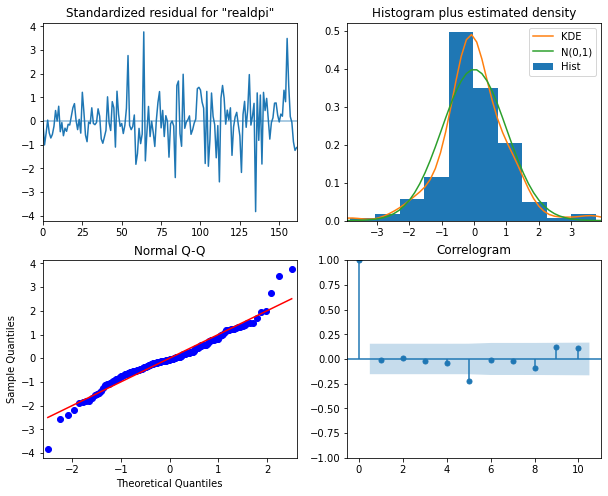

In [10]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

The significant coefficient at lag 5 in the correlogram is likely due to chance, since all other coefficients are non-significant. Here, the visual inspection of the residuals passes.

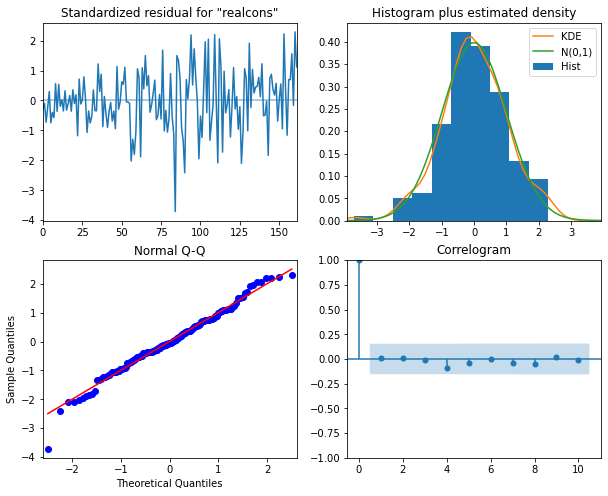

In [11]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [12]:
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.91401595 0.98538364 0.99457283 0.98423483 0.10349681 0.16446609
 0.23381342 0.21256818 0.14871658 0.12192061]


In [13]:
realcons_residuals = best_model_fit.resid['realcons']

lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.87780724 0.9662442  0.99530283 0.99358114 0.99592464 0.99241215
 0.9945819  0.97605699 0.98253113 0.99168547]


In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMA':

        realdpi_pred_VARMA = []
        realcons_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMA.extend(oos_pred_realdpi)
            realcons_pred_VARMA.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMA, realcons_pred_VARMA
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [15]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

In [16]:
test = endog[163:]

test['realdpi_pred_VARMA'] = pd.Series()
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)

test['realcons_pred_VARMA'] = pd.Series()
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA)

In [17]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [18]:
test.head()

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224196,7354.322736,7716.0,7199.9
164,8053.4,7501.3,7897.188510,7430.252289,7716.0,7199.9
165,8135.9,7571.8,7960.563582,7496.625536,7716.0,7199.9
166,8222.3,7645.9,8014.755219,7556.608335,7716.0,7199.9
167,8234.6,7713.5,8080.701325,7630.992271,8135.9,7571.8


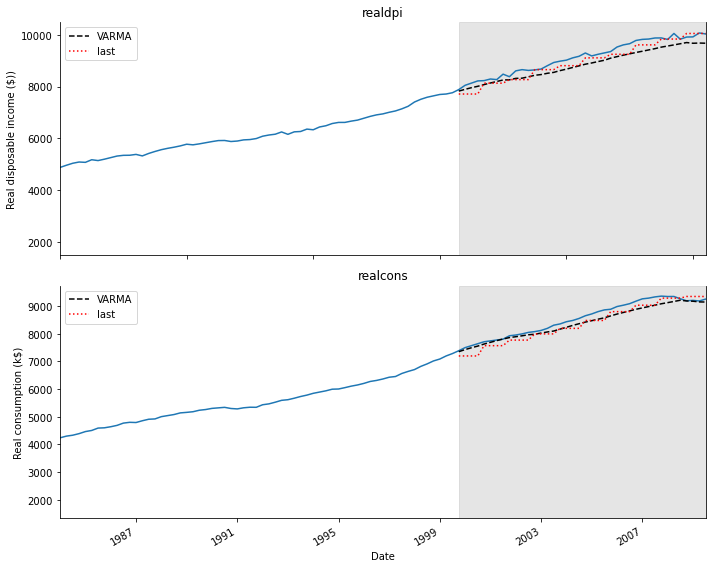

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMA'], 'k--', label='VARMA')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMA'], 'k--', label='VARMA')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

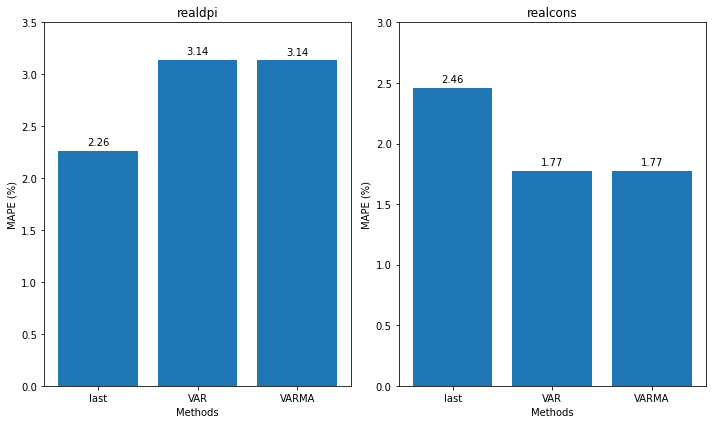

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR', 'VARMA']
y1 = [mape_realdpi_last, 3.14, mape_realdpi_VARMA]    # From chapter 10, VAR model achieved a MAPE of 3.14%
y2 = [mape_realcons_last, 1.77, mape_realcons_VARMA]  # From chapter 10, VAR model achieved a MAPE of 1.77%

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

Using a VARMA model did not change anything, since the VARMA(3,0) achieved the lowest AIC, which is equivalent to a VAR(3) model, just like we obtained in chapter 10. Let's try a VARMAX model to see if we can get an improvement.

## Use a VARMAX model to predict `realdpi` and `realcons` 

In [23]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Select the exogenous variables. Note that they do not be to be stationary to be used
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])
# Make sure that the index of exog is aligned with train
exog = macro_econ_data[exog_cols][1:163]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMAX = optimize_VARMAX(train, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.478554
1,"(2, 0)",3117.855527
2,"(1, 1)",3119.158962
3,"(0, 1)",3120.096864
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398467
6,"(0, 2)",3123.637218
7,"(1, 2)",3125.051543
8,"(1, 3)",3126.776710
9,"(2, 1)",3126.805587


From the selection process, $p=1$ and $q=0$.

In [25]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


The p-value for "realdpi Granger-causes realcons" is only very slightly larger than 0.05. Thus, we decide to move forward with the model.

In [26]:
best_model = VARMAX(train, exog, order=(1,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                             VARX(1)   Log Likelihood               -1527.739
                               + intercept   AIC                           3113.479
Date:                     Tue, 11 Jan 2022   BIC                           3203.019
Time:                             16:26:15   HQIC                          3149.833
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.08, 0.29   Jarque-Bera (JB):         40.65, 18.60
Prob(Q):                        0.78, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         5.81, 2.63   Skew:                      0.12

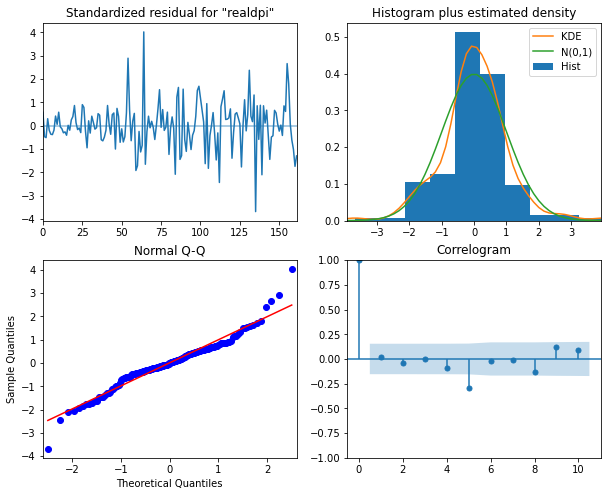

In [27]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

Again, the significant coefficient at lag 5 is likely due to chance. The visual inspection of the residuals passes.

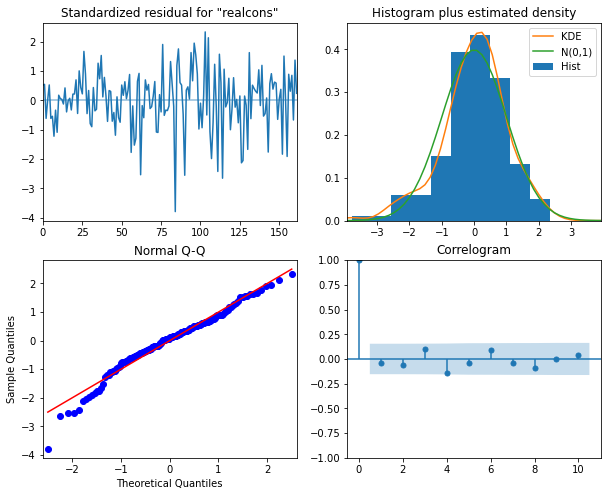

In [28]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

In [29]:
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.78299935 0.81428989 0.93787084 0.77489333 0.00629278 0.0123918
 0.02245051 0.01355394 0.00897401 0.00915208]


Here, we see that the p-value is less than 0.05 starting at lag 5. This is worrying becasue it seems that the residuals of `realdpi` are correlated starting at lag 5. For the sake of completing the exercise, let's keep going, especially becasue the visual inspection of the residuals all point to the conclusion that the residuals behave like white noise.

You can see that sometimes, there is a bit of judgement to be made when we are in a grey zone.

In [30]:
realcons_residuals = best_model_fit.resid['realcons']

lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.60575356 0.36444234 0.07741952 0.04792856 0.04773094 0.03721442
 0.05691694 0.02146049 0.03553023 0.05136182]


In [31]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    # Use the exogenous variable to 
                                                                                       # generate predictions
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMAX, realcons_pred_VARMAX
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [32]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # We can only predict the next timestep, since we have exogenous variables (just like the SARIMAX model)

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [33]:
test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

In [34]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

In [35]:
test.head()

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7953.527744,7272.921643,7716.0,7199.9
164,8053.4,7501.3,8096.109712,7288.869056,7765.9,7286.4
165,8135.9,7571.8,8113.617110,7296.744331,7887.7,7389.2
166,8222.3,7645.9,8146.655080,7351.878081,8053.4,7501.3
167,8234.6,7713.5,8197.832948,7440.200283,8135.9,7571.8


In [36]:
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

In [38]:
print(mape_realdpi_VARMAX)

25.680661636365148


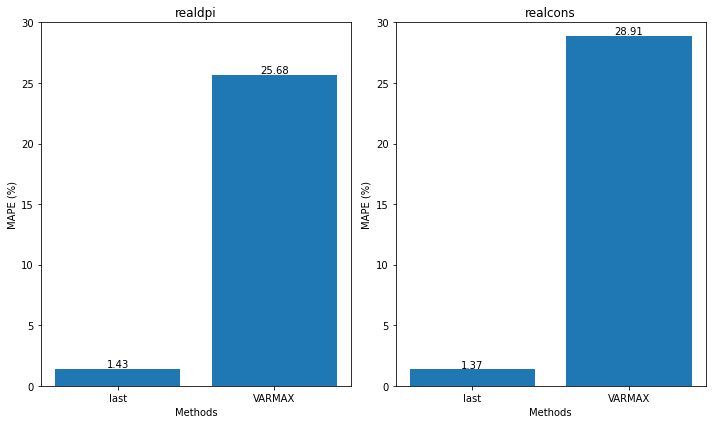

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]   
y2 = [mape_realcons_last, mape_realcons_VARMAX] 

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()

Clearly, using a VARMAX model is a very bad idea in this situation, since it achieves a very high MAPE compared to a simple baseline.
Note that we cannot compare this performance to the VAR and VARMA models, since the forecast window is different for VARMAX.